In [2]:
import pandas as pd
import numpy as np
import zipfile
# For data visualization
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
# import plotly.offline as po
# import plotly.graph_objs as go

# For models
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,
    plot_confusion_matrix, plot_roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [3]:
loan = pd.read_csv('loan.csv')

loan.head()

,Unnamed: 0,loan_amnt,term,int_rate,sub_grade,home_ownership,annual_inc,verification_status,purpose,addr_state,...,pub_rec,revol_bal,revol_util,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,loan_status_flag,fico,earliest_cr_line_y
0,0,5000.0,36,10.65,B2,RENT,24000.0,Verified,credit_card,AZ,...,0.0,13648.0,83.7,f,Individual,2.0,0.0,0,737.0,36
1,1,2500.0,60,15.27,C4,RENT,30000.0,Source Verified,car,GA,...,0.0,1687.0,9.4,f,Individual,2.0,0.0,1,742.0,22
2,2,2400.0,36,15.96,C5,RENT,12252.0,Not Verified,small_business,IL,...,0.0,2956.0,98.5,f,Individual,2.0,0.0,0,737.0,20
3,3,10000.0,36,13.49,C1,RENT,49200.0,Source Verified,other,CA,...,0.0,5598.0,21.0,f,Individual,2.0,0.0,0,692.0,25
4,4,3000.0,60,12.69,B5,RENT,80000.0,Source Verified,other,OR,...,0.0,27783.0,53.9,f,Individual,2.0,0.0,0,697.0,25


In [4]:
loan.columns

Index(['Unnamed: 0', 'loan_amnt', 'term', 'int_rate', 'sub_grade',
       'home_ownership', 'annual_inc', 'verification_status', 'purpose',
       'addr_state', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'initial_list_status', 'application_type', 'mort_acc',
       'pub_rec_bankruptcies', 'loan_status_flag', 'fico',
       'earliest_cr_line_y'],
      dtype='object')

In [5]:
loan.drop('Unnamed: 0',axis=1, inplace=True)

In [6]:
loan.shape

(1857132, 21)

## **Create Dummy Variables**

In [7]:
#Find all the categorical variables
dummy = [column for column in loan.columns if loan[column].dtype == object]
dummy

['sub_grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'addr_state',
 'initial_list_status',
 'application_type']

In [8]:
loan = pd.get_dummies(loan, columns=dummy, drop_first=True)

In [9]:
# plt.figure(figsize=(7,16))
# loan.corr().loan_status_flag.sort_values()[:-1].plot.barh()
# plt.title('Correlation of Charged Off with Features')

## **Train Test Split**

In [10]:
X = loan.drop('loan_status_flag', axis=1)
y = loan['loan_status_flag']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=666)

In [12]:
print("X_train.shape: ", X_train.shape)
print("X_test.shape:  ", X_test.shape)
print("y_train.shape: ", y_train.shape)
print("y_test.shape:  ", y_test.shape)

X_train.shape:  (1485705, 117)
X_test.shape:   (371427, 117)
y_train.shape:  (1485705,)
y_test.shape:   (371427,)


## Downsampling

In [13]:
loan['loan_status_flag'].mean()

0.19489137013416385

In [14]:
loan_positive = loan[loan['loan_status_flag']==1]
loan_negative = loan[loan['loan_status_flag']==0]

In [15]:
loan_positive.shape, loan_negative.shape

((361939, 118), (1495193, 118))

In [16]:
loan_negative_sample = loan_negative.sample(n=loan_positive.shape[0], random_state=2021)

In [17]:
loan_positive.shape, loan_negative_sample.shape

((361939, 118), (361939, 118))

In [18]:
loan_downsample = pd.concat([loan_positive, loan_negative_sample])

In [19]:
loan_downsample.shape

(723878, 118)

In [20]:
X_down = loan_downsample.drop('loan_status_flag', axis=1)
y_down = loan_downsample['loan_status_flag']
X_down_train, X_down_test, y_down_train, y_down_test = train_test_split(X_down, y_down, test_size=0.2,stratify=y_down, random_state=2021)

# **Models Building**

First, define a function to output accuracy scor, classification report and confusion matrix.

In [23]:
def output(model, xtrain, ytrain, xtest, ytest):
    test_pred = model.predict(xtest)
    train_pred = model.predict(xtrain)
    test_pred_prob = model.predict_proba(xtest)
    train_pred_prob = model.predict_proba(xtrain)
    # The roc_auc_score need to feed in y_true and y_score
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html?highlight=roc_auc_score#sklearn.metrics.roc_auc_score
    train_roc_score = np.round(roc_auc_score(ytrain, train_pred_prob[:, 1], average='micro'),4)
    test_roc_score = np.round(roc_auc_score(ytest, test_pred_prob[:, 1], average='micro'),4)    
    train_acc_score = np.round(accuracy_score(ytrain, train_pred),4)
    test_acc_score = np.round(accuracy_score(ytest, test_pred),4)
    print('ROC score on train data:', train_roc_score)
    print('ROC score on test data:', test_roc_score)
    print('Accuracy score on train data:', train_acc_score)
    print('Accuracy score on test data:', test_acc_score)
    print('Classification Report:\n',classification_report(ytest, test_pred))
    print('Confusion Matrix:\n', confusion_matrix(ytest, test_pred))
    return (train_roc_score,test_roc_score,train_acc_score, test_acc_score)

In [21]:
# prediction_model_list = ['Logistic Regression', 'Random Forest Classifier','XGBoost Classifier']
# cols = pd.MultiIndex.from_product([['ROC Score','Accuracy Score'],['Train','Test']])
# score = pd.DataFrame(columns=cols, index=prediction_model_list)

## 1. Logistic Regression

### 1.1 Naive logistric regression

In [22]:
# lr_v0: no scaler
lr_v0 = LogisticRegression(max_iter=1000)
lr_v0.fit(X_train, y_train)

Wall time: 16min 26s


LogisticRegression(max_iter=1000, n_jobs=-1)

In [23]:
perf_lr_v0 = output(lr_v0, X_train, y_train, X_test, y_test) 

ROC score on train data: 0.6974
ROC score on test data: 0.6974
Accuracy score on train data: 0.8052
Accuracy score on test data: 0.8055
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.99      0.89    299039
           1       0.51      0.06      0.11     72388

    accuracy                           0.81    371427
   macro avg       0.66      0.52      0.50    371427
weighted avg       0.75      0.81      0.74    371427

Confusion Matrix:
 [[294849   4190]
 [ 68064   4324]]


### 1.2 MinMaxScaler to normalize the features

Next, we try to use the `MinMaxScaler` to normalize the data before feeding them into the model

In [24]:
# we need to use normalized train data in Logistic Regression
scaler = MinMaxScaler()
X_train_n = scaler.fit_transform(X_train)
X_test_n = scaler.transform(X_test)

In [25]:
lr_v1 = LogisticRegression(max_iter=1000)
lr_v1.fit(X_train_n, y_train)

LogisticRegression(max_iter=1000)

In [26]:
perf_lr_v1 = output(lr_v1, X_train_n, y_train, X_test_n, y_test) 

ROC score on train data: 0.7052
ROC score on test data: 0.7056
Accuracy score on train data: 0.8065
Accuracy score on test data: 0.8067
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.99      0.89    299039
           1       0.55      0.04      0.08     72388

    accuracy                           0.81    371427
   macro avg       0.68      0.52      0.49    371427
weighted avg       0.76      0.81      0.73    371427

Confusion Matrix:
 [[296556   2483]
 [ 69296   3092]]


The ROC score has a little improvement here.

Text(0.5, 1.0, 'Confusion Matrix of Logistic Regression')

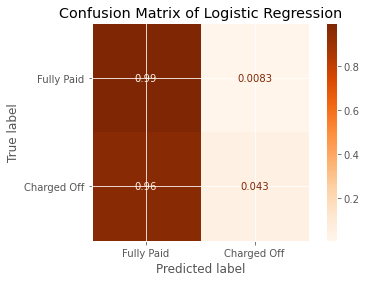

In [35]:
plot_confusion_matrix(
    lr_v1, X_test_n, y_test, cmap='Oranges',normalize='true',
    display_labels=['Fully Paid','Charged Off'])
plt.title('Confusion Matrix of Logistic Regression')

### 1.3 Downsampling

In [27]:
lr_v2 = LogisticRegression(max_iter=1000)
lr_v2.fit(X_down_train, y_down_train)

LogisticRegression(max_iter=1000)

In [28]:
perf_lr_v2 = output(lr_v2, X_down_train, y_down_train, X_down_test, y_down_test) 

ROC score on train data: 0.6808
ROC score on test data: 0.6827
Accuracy score on train data: 0.6214
Accuracy score on test data: 0.6236
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.72      0.66     72388
           1       0.65      0.53      0.58     72388

    accuracy                           0.62    144776
   macro avg       0.63      0.62      0.62    144776
weighted avg       0.63      0.62      0.62    144776

Confusion Matrix:
 [[52044 20344]
 [34152 38236]]


Text(0.5, 1.0, 'Confusion Matrix of Logistic Regression')

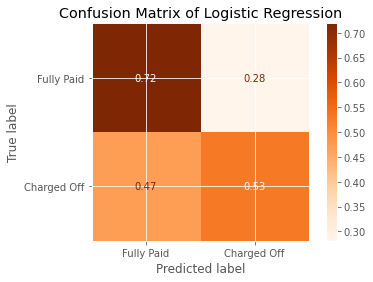

In [36]:
plot_confusion_matrix(
    lr_v2, X_down_test, y_down_test, cmap='Oranges', 
    normalize='true',
    display_labels=['Fully Paid','Charged Off'])
plt.title('Confusion Matrix of Logistic Regression')

In [37]:
# plot1 = plot_roc_curve(lr_v2, X_down_test, y_down_test)
# plt.title('ROC Score of Logistic Regression')

## 2. Random Forest Classifier
### 2.1 Naive RF

In [39]:
rf_v0 = RandomForestClassifier(n_jobs = -1)
rf_v0.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [40]:
perf_rf_v0 = output(rf_v0, X_train, y_train, X_test, y_test)

ROC score on train data: 1.0
ROC score on test data: 0.7022
Accuracy score on train data: 1.0
Accuracy score on test data: 0.807
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.99      0.89    299039
           1       0.55      0.06      0.10     72388

    accuracy                           0.81    371427
   macro avg       0.68      0.52      0.50    371427
weighted avg       0.76      0.81      0.74    371427

Confusion Matrix:
 [[295690   3349]
 [ 68328   4060]]


Overfitting is a concern because the accuracy and rocauc are both 1.0 on the train data.


### 2.2 Downsampling RF

In [49]:
rf_v1 = RandomForestClassifier(n_jobs = -1)
rf_v1.fit(X_down_train, y_down_train)

RandomForestClassifier(n_jobs=-1)

In [55]:
rf_v1.n_estimators, rf_v1.min_samples_leaf

(100, 1)

In [50]:
perf_rf_v1 = output(rf_v1, X_down_train, y_down_train, X_down_test, y_down_test)

ROC score on train data: 1.0
ROC score on test data: 0.7068
Accuracy score on train data: 1.0
Accuracy score on test data: 0.6504
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.64      0.65     72388
           1       0.65      0.66      0.65     72388

    accuracy                           0.65    144776
   macro avg       0.65      0.65      0.65    144776
weighted avg       0.65      0.65      0.65    144776

Confusion Matrix:
 [[46358 26030]
 [24584 47804]]


Text(0.5, 1.0, 'Confusion Matrix of Random Forest')

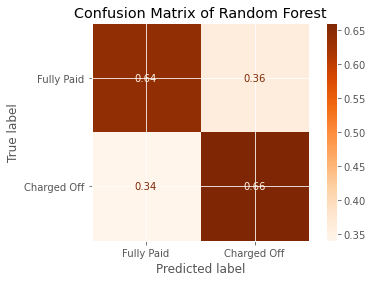

In [51]:
plot_confusion_matrix(
    rf_v1, X_down_test, y_down_test, cmap='Oranges', 
    normalize='true',
    display_labels=['Fully Paid','Charged Off'])
plt.title('Confusion Matrix of Random Forest')

We see some improvement here compared to the logistic regression.

## 3. XGBoost 
### 3.1 First try, downsampling

In [56]:
xgb_v1= XGBClassifier(use_label_encoder=False)
xgb_v1.fit(X_down_train, y_down_train)

[23:45:44] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [57]:
perf_xgb_v1 = output(xgb_v1, X_down_train, y_down_train, X_down_test, y_down_test)

ROC score on train data: 0.7371
ROC score on test data: 0.7176
Accuracy score on train data: 0.6723
Accuracy score on test data: 0.6573
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.64      0.65     72388
           1       0.65      0.68      0.66     72388

    accuracy                           0.66    144776
   macro avg       0.66      0.66      0.66    144776
weighted avg       0.66      0.66      0.66    144776

Confusion Matrix:
 [[46071 26317]
 [23301 49087]]


Text(0.5, 1.0, 'Confusion Matrix of Random Forest')

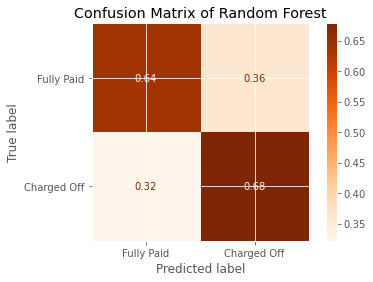

In [61]:
plot_confusion_matrix(
    xgb_v1, X_down_test, y_down_test, cmap='Oranges', 
    normalize='true',
    display_labels=['Fully Paid','Charged Off'])
plt.title('Confusion Matrix of Random Forest')

### 3.2 Hyper-parameter tuning
Let's try some model tuning using randomized search cv

In [21]:
from scipy import stats
param_grid = dict(
    n_estimators=stats.randint(10, 500),
    max_depth=stats.randint(1, 10),
    learning_rate=stats.uniform(0, 1),
    subsample=stats.uniform(0.5, 1)
)

xgb_clf = XGBClassifier(use_label_encoder=False)
xgb_cv = RandomizedSearchCV(
    xgb_clf, param_grid, cv=3, n_iter=60, 
    scoring='roc_auc', n_jobs=-1, verbose=1
)
xgb_cv.fit(X_down_train, y_down_train)

best_params = xgb_cv.best_params_
# best_params['tree_method'] = 'gpu_hist'
# # best_params = {'n_estimators': 50, 'tree_method': 'gpu_hist'}
print(f"Best Parameters: {best_params}")

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 572.3min finished


[09:41:32] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Parameters: {'learning_rate': 0.6947205003833099, 'max_depth': 2, 'n_estimators': 400, 'subsample': 0.9956886580631629}


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:42:26] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.6947205003833099, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.9956886580631629, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [ ]:
# Best after search
# XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
#               importance_type='gain', interaction_constraints='',
#               learning_rate=0.6947205003833099, max_delta_step=0, max_depth=2,
#               min_child_weight=1, missing=nan, monotone_constraints='()',
#               n_estimators=400, n_jobs=12, num_parallel_tree=1, random_state=0,
#               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
#               subsample=0.9956886580631629, tree_method='exact',
#               validate_parameters=1, verbosity=None)

In [26]:
xgb_v2 = XGBClassifier(**best_params)
xgb_v2.fit(X_down_train, y_down_train)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:06:40] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.6947205003833099, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.9956886580631629, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [27]:
perf_xgb_v2 = output(xgb_v2, X_down_train, y_down_train, X_down_test, y_down_test)

ROC score on train data: 0.723
ROC score on test data: 0.7189
Accuracy score on train data: 0.6623
Accuracy score on test data: 0.6584
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.64      0.65     72388
           1       0.65      0.68      0.66     72388

    accuracy                           0.66    144776
   macro avg       0.66      0.66      0.66    144776
weighted avg       0.66      0.66      0.66    144776

Confusion Matrix:
 [[46345 26043]
 [23416 48972]]


Text(0.5, 1.0, 'Confusion Matrix of Logistic Regression')

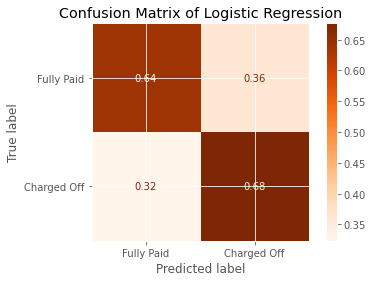

In [28]:
plot_confusion_matrix(
    xgb_v2, X_down_test, y_down_test, cmap='Oranges', 
    normalize='true',
    display_labels=['Fully Paid','Charged Off'])
plt.title('Confusion Matrix of Logistic Regression')

Improved a very little on the ROC.